In [3]:
using PyPlot
using LinearAlgebra
using Statistics
using Random
import Base.MathConstants.e

# Adaptive Learning Rates

Let's look at using stochastic gradient descent with various methods to optimize logistic regression.
First, we'll generate a training set at random from the generative model associated with logistic regression.
(The same generative model we used for Notebook 6.)

Except: here to create some imbalance in the examples, we'll adjust the sampled $X$ to have different variances in different coordinates.

In [4]:
# generate the data
Random.seed!(424242)
d = 50;
N = 10000;
wtrue = randn(d);
wtrue = d^2 * wtrue / norm(wtrue);
X = randn(N, d);
X ./= sqrt.(sum(X.^2; dims=2));
Y = (1 ./ (1 .+ exp.(-X * wtrue)) .>= rand(N)) .* 2 .- 1;
sigma = 1e-4;

Let's do logistic regression with regularization here, just as we did before to study hyperparameter optimization.

In [5]:
w0 = randn(d);

In [6]:
function sgd_logreg(w0, alpha0, gamma, X, Y, sigma, niters, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters)
    for k = 1:niters
        alpha = alpha0 / (1 + gamma * (k-1));
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        w = (1 - alpha * sigma) * w + alpha * xi * yi / (1 .+ exp.(yi * dot(xi, w)));
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

function adagrad_logreg(w0, alpha, X, Y, sigma, niters, wopt)
    w = w0;
    (N, d) = size(X);
    r = zeros(d);
    dist_to_optimum = zeros(niters);
    for k = 1:niters
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        g = sigma * w - xi * yi / (1 .+ exp.(yi * dot(xi, w)));
        r += g.^2;
        w -= alpha * g ./ (sqrt.(r) .+ 1e-10); 
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

adagrad_logreg (generic function with 1 method)

In [7]:
# find the true minimum
function newton_logreg(w0, X, Y, sigma, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = -X' * (Y ./ (1 .+ exp.(Y .* (X * w)))) + N * sigma * w;
        H = X' * ((1 ./ ((1 .+ exp.(Y .* (X * w))) .* (1 .+ exp.(-Y .* (X * w))))) .* X) + N * sigma * I;
        w = w - H \ g;
        println("gradient norm: $(norm(g))")
    end
    return w
end

newton_logreg (generic function with 1 method)

In [8]:
wopt = newton_logreg(wtrue, X, Y, sigma, 20);

gradient norm: 2500.000416184221
gradient norm: 568.5321463634123
gradient norm: 162.2081388505692
gradient norm: 59.13057294638611
gradient norm: 16.10911785249323
gradient norm: 1.864245478061334
gradient norm: 0.02947084402265636
gradient norm: 7.507787778566566e-6
gradient norm: 4.872576446772484e-13
gradient norm: 2.613891556799585e-14
gradient norm: 2.3055729862370177e-14
gradient norm: 2.4584296439553133e-14
gradient norm: 2.184594791303772e-14
gradient norm: 2.5875997830454982e-14
gradient norm: 2.391654643720554e-14
gradient norm: 2.1902789798638662e-14
gradient norm: 2.138310873593704e-14
gradient norm: 2.6659125626953916e-14
gradient norm: 2.3794672214487743e-14
gradient norm: 2.3505105453973415e-14


In [9]:
# do some simple hyperparameter optimization
best_distance_sgd = 1e8;
alpha_best_sgd = 0.0;
for alpha in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0]
    (w, dto) = sgd_logreg(w0, alpha, 0.0, X, Y, sigma, 100000, wopt);
    if dto[length(dto)] < best_distance_sgd
        best_distance_sgd = dto[length(dto)];
        alpha_best_sgd = alpha;
    end
end

println("best sgd: (alpha = $alpha_best_sgd)")

best_distance_adagrad = 1e8;
alpha_best_adagrad = 0.0;
for alpha in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0]
    (w, dto) = adagrad_logreg(w0, alpha, X, Y, sigma, 100000, wopt);
    if dto[length(dto)] < best_distance_adagrad
        best_distance_adagrad = dto[length(dto)];
        alpha_best_adagrad = alpha;
    end
end

println("best adagrad: (alpha = $alpha_best_adagrad)")

best sgd: (alpha = 0.1)
best adagrad: (alpha = 1.0)


In [14]:
Random.seed!(123456);
(w, dto) = sgd_logreg(w0, alpha_best_sgd, 0.0, X, Y, sigma, 100000, wopt);
(w2, dto2) = adagrad_logreg(w0, 0.5*alpha_best_adagrad, X, Y, sigma, 100000, wopt);

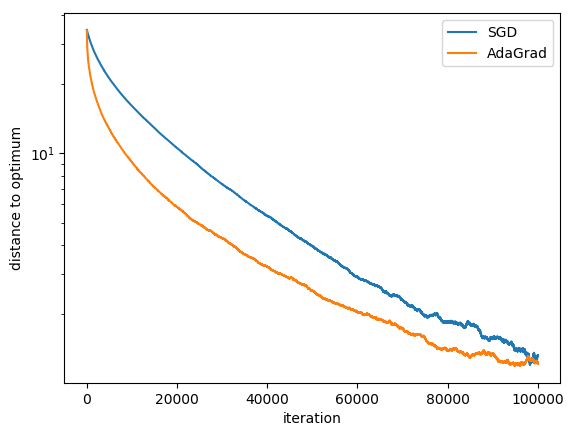

In [15]:
semilogy(dto; label="SGD");
semilogy(dto2; label="AdaGrad");
legend();
xlabel("iteration");
ylabel("distance to optimum");

Conclusion: AdaGrad can beat constant-step-size SGD for some problems, with equivalent hyperparameter optimization.

# Part 2: Inference

## Let's compare latency and throughput for an inference task

Simple linear model for multiclass regression.

$$\hat y(x) = \arg \max_{i \in \{1, \ldots, c\}} w_i^T x$$

In [10]:
# number of classes
c = 64;

# dimension of model
d = 256 * 1024;

# number of test examples
n = 1024;

# random weight matrix
w = randn(c, d);

# test examples
x = randn(d, n);

In [11]:
function predict(w::Array{Float64,2}, x::Array{Float64,2})
    wx = w*x;
    return [findmax(wx[:,i])[2] for i = 1:size(x,2)];
end

predict (generic function with 1 method)

Suppose we want to make a prediction for all $n = 1024$ test examples. How long will this take us?

In [12]:
# first run of predictions to make sure everything is compiled
predict(w, x);

# now time the time it takes to predict
(predictions, elapsed) = @timed predict(w, x);

println("latency: took $elapsed seconds to return predictions");
println("throughput: on average, $(n/(elapsed)) predictions/second");

latency: took 0.389324806 seconds to return predictions
throughput: on average, 2630.1945938682366 predictions/second


Now what if we make a prediction for just one isolated example?

In [13]:
(predictions, elapsed) = @timed predict(w, x[:,1:1]);

println("latency: took $elapsed seconds to return predictions");
println("throughput: on average, $(1/(elapsed)) predictions/second");

latency: took 0.0635057 seconds to return predictions
throughput: on average, 15.746618020114731 predictions/second


What happened?

The latency went down, but so did the throughput.

This exposes a tradeoff: if we can batch examples to be inferred, we can usually raise the throughput...but this comes at a cost of higher latency!

In [14]:
batch_size = [1,2,4,8,16,32,64,128,256,512,1024];
latencies = zeros(length(batch_size));
throughputs = zeros(length(batch_size));

for i = 1:length(batch_size)
    xsi = copy(x[:,1:batch_size[i]]);
    (predictions, elapsed) = @timed predict(w, xsi);
    
    latencies[i] = elapsed;
    throughputs[i] = batch_size[i] / elapsed;
end

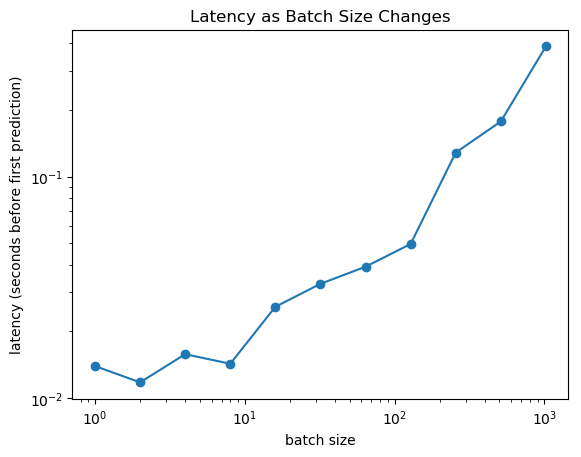

In [15]:
loglog(batch_size, latencies, "-o");
title("Latency as Batch Size Changes");
xlabel("batch size");
ylabel("latency (seconds before first prediction)");

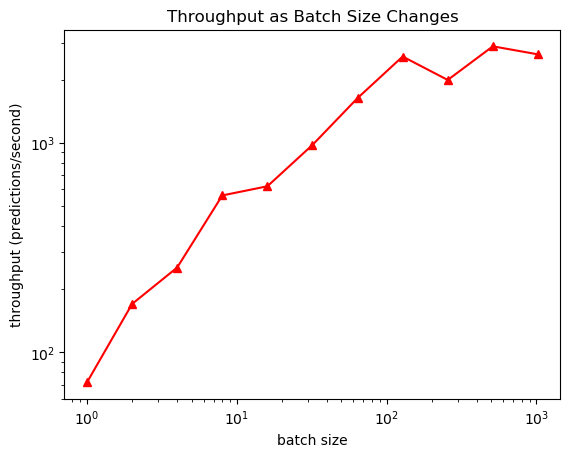

In [16]:
loglog(batch_size, throughputs, "-^r");
title("Throughput as Batch Size Changes");
xlabel("batch size");
ylabel("throughput (predictions/second)");